# Implementation of user locations inference

In [15]:
# install geopy and folium which are not contained by jupyter notebook

import pip

def install(package):
   pip.main(['install', package])

install('geopy') 
install('folium')


In [16]:
# import needed packages

from pymongo import MongoClient
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import numpy as np
from geopy.geocoders import Nominatim
import folium


client = MongoClient()
db = client.testYelp

In [17]:
# predict users' city/geo-location based on business they have reviewed

def location_prediction(userId_cities, user_geos):
    locations = {}
    geos = {}
    for user, cities in userId_cities.items():
        if not cities:
            continue
        city = Counter(cities).most_common(1)
        locations[user] = city[0][0]
    for user, geo in user_geos.items():
        if not geo:
            continue
        geo = Counter(geo).most_common(1)
        geos[user] = geo[0][0]
    return locations, geos


In [18]:
# parse all reviews from database and get userId and list of businessId respectively
# default filter users with less than 5 reviews and get 10 most recent reviews for each user

def getReviews(minLength=5,topNum=0):
    userId_businessId = {}
    user_reviews = db.review.find({},{"user_id":1,"business_id":1,"date":1})
    
    # get all reviews from database
    for user_review in user_reviews:
        if user_review['user_id'] not in userId_businessId:
            userId_businessId[user_review['user_id']] = []
        date = ''.join(user_review['date'].split('-'))
        userId_businessId[user_review['user_id']].append((user_review['business_id'],date))
        
    # filter the users with reviews number less than minLength and extract topNum recent reviews
    result={}
    for key,value in userId_businessId.items():
        if len(value)<minLength:
            continue
        if len(value)>topNum and topNum!=0:
            value = value[:topNum-1]
        # sort values by dates of reviews
        value = sorted(value, key=lambda x:x[1],reverse=True)
        result[key]=value
    # return merely the user and its corresponding list of businessId
    return {k:[val[0] for val in v] for k, v in result.items()}

In [19]:
# parse business and get its city and geo-location respectively

def business_loc():
    business_loc = {}
    business_geo = {}
    cities = db.business.find({}, {"business_id":1,"city":1,"latitude":1,"longitude":1})
    for city in cities:
        business_loc[city["business_id"]] = city['city']
        business_geo[city["business_id"]] = (city['latitude'],city['longitude'])
    return business_loc, business_geo

In [20]:
# connect users with lists of cities via business

def getCities(user_business, business_cities, business_geo):
    user_cities = {}
    user_geo = {}
    for user, business in user_business.items():
        user_cities[user] = [business_cities[b] for b in business]
        user_geo[user] = [business_geo[b] for b in business]
    return user_cities, user_geo

In [21]:
# get business cities and geo-locations
business_locations, business_geos = business_loc()

# predict user cities by all their reviews
userId_businessId = getReviews()
user_geo, user_cities = getCities(userId_businessId, business_locations, business_geos)
user_predict_geos, user_predict_locations = location_prediction(user_cities, user_geo)
user_locations = user_predict_locations.values()
user_geos = user_predict_geos.values()

print('half is done')

# predict user cities by their 5 most reviews with 3 as minimum required number of reviews
userId_businessId_recent = getReviews(5,5)
user_geo_recent, user_cities_recent = getCities(userId_businessId_recent, business_locations, business_geos)
user_predict_geos_recent, user_predict_locations_recent = location_prediction(user_cities_recent, user_geo_recent)
user_locations_recent = user_predict_locations_recent.values()
user_geos_recent = user_predict_geos_recent.values()

half is done


In [22]:
user_predict_locations

{'bjTcT8Ty4cJZhEOEo01FGA': 'Edinburgh',
 'yx8vNXUL0D0HS8rUIC7AFA': 'Montréal',
 'oU2SSOmsp_A8JYI7Z2JJ5w': 'Edinburgh',
 'zXnH6W74FAJQ7q7b-NuBsA': 'Edinburgh',
 'c5yp5hxwC1N98MjbV2LyWQ': 'Edinburgh',
 'AXgRULmWcME7J6Ix3I--ww': 'Edinburgh',
 'tgV6tsYQ66DZ3LQKvtC6cw': 'Las Vegas',
 'Q-3YCVywc03w56wYtGlKvg': 'Edinburgh',
 'eqWEgMH-DCP74i82BEAZzw': 'Toronto',
 'd0DGZRp6lHXGECJSc_nn-A': 'Edinburgh',
 'WZXp9-V2dqRRJqhGgRqueA': 'Mentor',
 'XylT12exfdLiI_3uDLVIpw': 'Glendale',
 'IpLZ7RevQrFPJWYc9Gxymg': 'Edinburgh',
 'E56sVQT5-OWfSejJrma8_w': 'Phoenix',
 'TLIWzAJPrET0zX4_vgvLhg': 'Surprise',
 'Ji9PeffxjwqPLO7pEfSpKQ': 'Surprise',
 'P8mVj7AZwJTFFH5FXbbmUg': 'Surprise',
 'JZEiTNWBwmv6MOOXYCAaMQ': 'Surprise',
 'vgZqQqe8cj6SBMH0EqDliw': 'Scottsdale',
 'O7G_c6wFXSygr82qs0GAcA': 'Peoria',
 'UG4EKu13JRwzRix6ESINdg': 'Surprise',
 '1YorWW0Z-YDuYC5GplNabw': 'Surprise',
 'R6vb0FtmClhfwajs_AuusQ': 'Phoenix',
 'CPuUagT2rfUJm6hRgxn3JQ': 'Phoenix',
 'OYRBjBWy1uOm12N3cokS_Q': 'Surprise',
 'PKZLwAGgBtQCjJtGhyPE

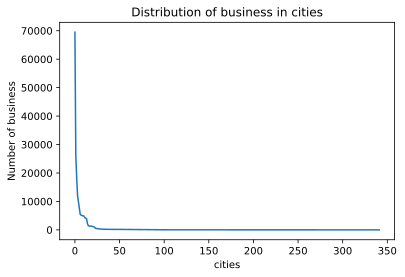

In [23]:
# show the distribution of business

counter_user_locs = Counter(user_locations)
counter_business_loc = Counter(business_locations.values())
counter_user_locs_recent = Counter(user_locations_recent)
plt.plot(range(len(counter_user_locs)),sorted(counter_user_locs.values(),reverse=True))
plt.title('Distribution of business in cities')
plt.xlabel('cities')
plt.ylabel('Number of business')
plt.show()

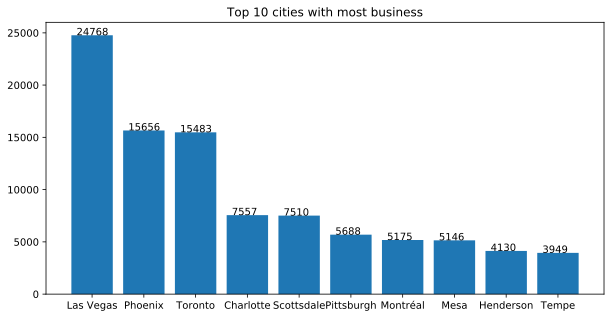

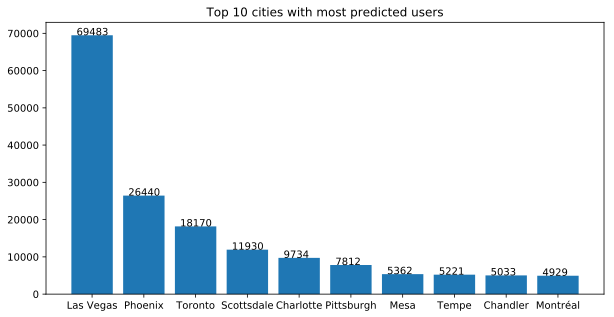

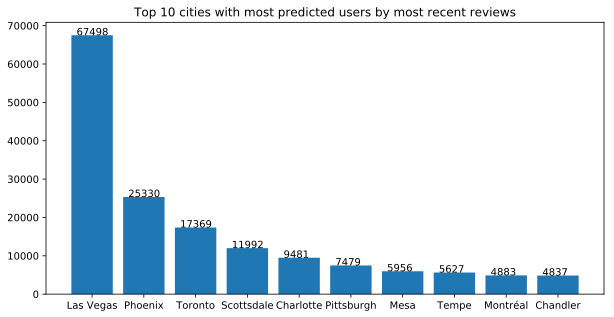

In [24]:
# find cities with most users

def top_cities_with_most_user(locs, text, num=10):
    plt.figure(figsize=(10,5))
    counter = Counter(locs)
    most_locations = counter.most_common(num)
    plt.bar(range(10),[a[1] for a in most_locations])
    for i,v in enumerate([a[1] for a in most_locations]):
        plt.text(i - .3, v + .7, str(v))
    plt.xticks(range(10), [a[0] for a in most_locations])
    plt.title(text)
    plt.show()    

top_cities_with_most_user(business_locations.values(), 'Top 10 cities with most business')
top_cities_with_most_user(user_locations, 'Top 10 cities with most predicted users')
top_cities_with_most_user(user_locations_recent, 'Top 10 cities with most predicted users by most recent reviews')

In [36]:
# draw the geo-location of cities and predicted cities

def map_plot(counter,topn = 10):
    geolocator = Nominatim()
    m = folium.Map(location=[40.5236, -100.6750], zoom_start = 4)
    time = 0
    sorted(counter.items(), key=lambda x:x[1], reverse=True)
    for city, count in counter.items():
        if time > topn:
            break
        lo = geolocator.geocode(city)
        if lo is None:
            continue
        folium.Marker(location=[lo.latitude,lo.longitude], popup="{}, {} businesses here".format(city, count)).add_to(m)
        time += 1
    return m

# draw the geo-location of cities with most business
map_plot(counter_user_locs,15)


In [28]:
# draw the geo-location of cities with most predicted users
map_plot(counter_user_locs,15)

In [30]:
# draw the geo-location of cities with most predicted users by recent reviews
map_plot(counter_user_locs_recent,15)

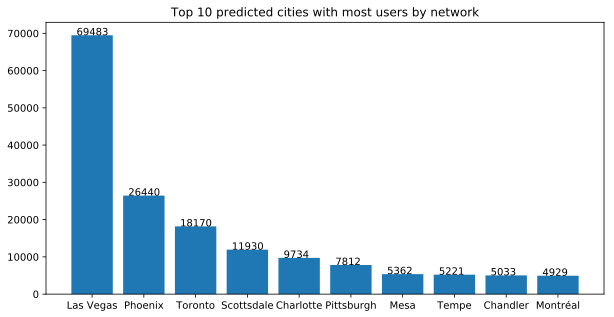

In [34]:
# generate the network of each users
def user_friends():
    user_friends_loc={}
    user_friends = db.user.find({}, {"user_id":1,"friends":1})
    for uf in user_friends:
        if uf['user_id'] not in user_friends_loc.keys():
            user_friends_loc[uf['user_id']] = []
            for f in uf['friends']:
                if f not in user_predict_locations.keys():
                    continue
                user_friends_loc[uf['user_id']].append(user_predict_locations[f])
    return user_friends_loc

# one more prediction based on users' network
_, user_predict_locations_friends = location_prediction(user_friends(), user_geo)
user_locations_friends = user_predict_locations_friends.values()
top_cities_with_most_user(user_locations_friends, 'Top 10 predicted cities with most users by network')

In [37]:
user_predict_locations_friends

{'bjTcT8Ty4cJZhEOEo01FGA': 'Edinburgh',
 'yx8vNXUL0D0HS8rUIC7AFA': 'Montréal',
 'oU2SSOmsp_A8JYI7Z2JJ5w': 'Edinburgh',
 'zXnH6W74FAJQ7q7b-NuBsA': 'Edinburgh',
 'c5yp5hxwC1N98MjbV2LyWQ': 'Edinburgh',
 'AXgRULmWcME7J6Ix3I--ww': 'Edinburgh',
 'tgV6tsYQ66DZ3LQKvtC6cw': 'Las Vegas',
 'Q-3YCVywc03w56wYtGlKvg': 'Edinburgh',
 'eqWEgMH-DCP74i82BEAZzw': 'Toronto',
 'd0DGZRp6lHXGECJSc_nn-A': 'Edinburgh',
 'WZXp9-V2dqRRJqhGgRqueA': 'Mentor',
 'XylT12exfdLiI_3uDLVIpw': 'Glendale',
 'IpLZ7RevQrFPJWYc9Gxymg': 'Edinburgh',
 'E56sVQT5-OWfSejJrma8_w': 'Phoenix',
 'TLIWzAJPrET0zX4_vgvLhg': 'Surprise',
 'Ji9PeffxjwqPLO7pEfSpKQ': 'Surprise',
 'P8mVj7AZwJTFFH5FXbbmUg': 'Surprise',
 'JZEiTNWBwmv6MOOXYCAaMQ': 'Surprise',
 'vgZqQqe8cj6SBMH0EqDliw': 'Scottsdale',
 'O7G_c6wFXSygr82qs0GAcA': 'Peoria',
 'UG4EKu13JRwzRix6ESINdg': 'Surprise',
 '1YorWW0Z-YDuYC5GplNabw': 'Surprise',
 'R6vb0FtmClhfwajs_AuusQ': 'Phoenix',
 'CPuUagT2rfUJm6hRgxn3JQ': 'Phoenix',
 'OYRBjBWy1uOm12N3cokS_Q': 'Surprise',
 'PKZLwAGgBtQCjJtGhyPE